# Hybrid Training

So for the retraining campaign, I started looking into training w/ a hybrid sample from Franscesco, so this is just starting to look at some results!

Dec 2018


**Table of Contents**
1. [Training Metrics from the Hybrid training](#trainingMetrics)
2. [Evaluation on $t\bar{t}$ and Z'](#hybridEval)
3. [Comparison to dedicated $t\bar{t}$ training](#cf_ttbarTraining)


In [4]:
# So that my notebook has flexibility to run with the hybrid or extended hybrid samples 
HYBRID_SAMPLE = "hybrid_5TeV"

In [5]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Training Metrics from the hybrid training <a id='trainingMetrics'></a>

In [6]:
subDir = 'mc16d_PFlow_{}'.format(HYBRID_SAMPLE)
dataDir = '../../data/'+subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
#dataTag = "3mtrain_15trks_{}_sd0_rev".format(vStr)
dataTagTrain = "5mtrain_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTrain)

f = h5py.File(f_name,"r")
    
X_tr = f['X_train'][:]
y_tr = f['y_train'][:]
ix_tr = f['ix_train'][:]
w_tr = f['weights_train'][:]

f.close()

In [7]:
_, nTrks, nFeatures = X_tr.shape

**Extending the model complexity**

Based on my studies in `Model-Complexity`, the hybrid training performs a lot better for a model with more capactity. Granted, I'm now not comparing apples to apples, since my $t\bar{t}$ training was for a simpler model, but at least this helps the hybrid performance!

In [5]:
modelDir = '../../models/'+subDir
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True, nHidden=200)

Initialize method from myModel()
Loading previously trained LSTM


In [6]:
m.modelName

'LSTM_200units_10dense_5mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev'

In [10]:
figDir = '../../figures'

leffs, ceffs, beffs = [], [], []
trainingMetrics(m.modelName,modelDir=modelDir)


NameError: name 'm' is not defined

In [8]:
%%bash
ls ../../models/mc16d_PFlow_hybrid_5TeV/

LSTM_200units_10dense_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_rwt-b.hdf5
LSTM_50units_10dense_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.hdf5
LSTM_50units_10dense_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_history.hdf5


It looks like the model has converged now.

In [8]:
df_tag = '5mtrain_15trks_sd0_rev'

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(dataDir,df_tag), key='jet_df')

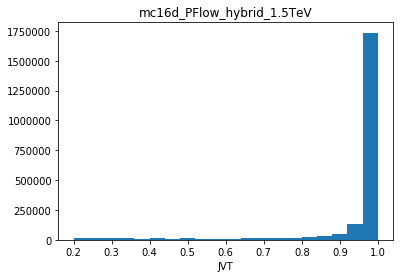

In [10]:
plt.hist(jet_df.loc[(jet_df.pt < 60) & (np.abs(jet_df.eta) < 2.4),'JVT'],bins=20)
plt.xlabel('JVT')
plt.title(subDir)
plt.show()

Ok, it looks like the JVT cut has been applied at the training stage!

Ok, for the training data, the values have not been shuffled.

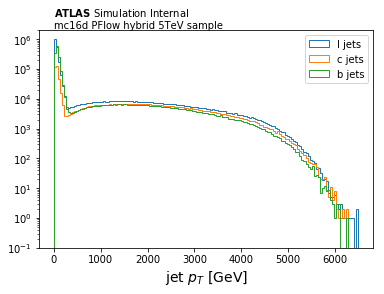

In [13]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+="mc16d PFlow {} sample".format(HYBRID_SAMPLE.replace("_"," "))

for flav,pdg in zip(['l','c','b'],[0,4,5]):
    
    plt.hist(jet_df.loc[jet_df.LabDr_HadF==pdg,'pt'],label='{} jets'.format(flav),
             bins=150,range=(0,6500),
             histtype='step',log=True)
    
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.legend()

ymax = 2e6
plt.ylim(.1,ymax)
plt.text(0,ymax,text,horizontalalignment='left', verticalalignment='bottom')
plt.savefig('{}/{}/jet_pT.pdf'.format(figDir,subDir))

plt.show()

In [14]:
subDir

'mc16d_PFlow_hybrid_5TeV'

### Sample weights

- I'm concerned why the training metrics are so noisy.
- Maybe this is due to my sample weights being too noisy? Right now (Dec 18 2018) I'm reweighting to the l-jet $p_T$ spectrum

Check the sample weights vs the jet $p_T$ for this way of reweighting the jet $p_T$ spectrum.

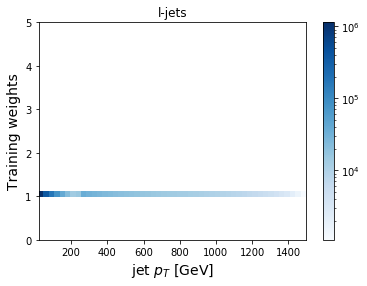

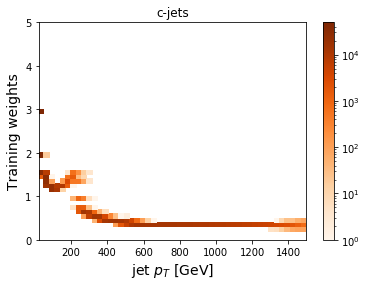

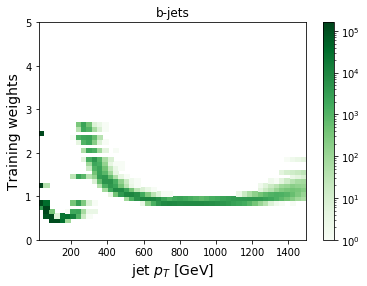

In [12]:
pTRange = (20,1500) if '1.5TeV' in HYBRID_SAMPLE else (0,5000)


for yi,flav,cmap in zip([0,1,2],['l','c','b'],['Blues','Oranges','Greens']):
    
    mask = (y_tr == yi)
    
    plt.figure()
    plt.hist2d(jet_df.loc[mask,'pt'],
               w_tr[mask],cmap=cmap,bins=50,range=(pTRange,(0,5)),norm=LogNorm())
    plt.colorbar()
    
    plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
    plt.ylabel('Training weights',fontsize=14)
    plt.title(flav+'-jets')
    plt.savefig('{}/{}/{}-jet_sampleWeights.pdf'.format(figDir,subDir,flav))

**Thoughts:**

In the algs meeting from $13^{th}$ Dec 2018, they suggested that I instead reweight to the smoother b-jet $p_T$ spectrum as the high level tagger teams said this scheme helped their performance.

## 2. Evaluation on $t\bar{t}$ and $Z'$ <a id='hybridEval'></a>

Last night my $t\bar{t}$ finished, so I can evaluate the performance separately on two separate physics samples.

In [13]:
leffs, ceffs, beffs, discs = [],[],[],[]

In [14]:
jetPts = []
ys = []

min: -6.76, max: 13.07


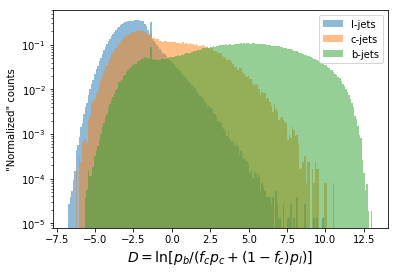

min: -7.13, max: 12.61


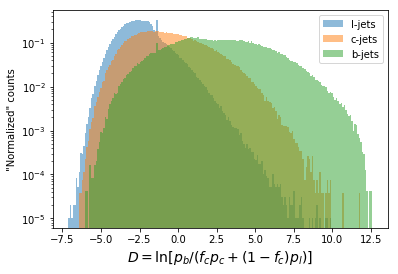

In [15]:
for physicsSample in ['ttbar','Zprime_1.5TeV']:
    
    # Open the file
    subDir = 'mc16d_PFlow_{}'.format(physicsSample)
    dataDir = '../../data/'+subDir
    dataTag = "2mtest_15trks_{}_sd0_rev_{}_scale".format(vStr,HYBRID_SAMPLE)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTag)

    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()
    
    # Additionally, get the jet pts for this study
    df = pd.read_hdf('{}/jet_2mtest_15trks_sd0_rev.h5'.format(dataDir), key='jet_df')
    
    # For the test set, you don't need ix
    jetPts.append(df.pt)
    ys.append(y)
    
    # Get the discriminant
    (leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                      figDir=figDir, subDir=subDir,
                                      tag='eval_{}'.format(physicsSample))

    leffs.append(leff)
    ceffs.append(ceff)
    beffs.append(beff)
    discs.append(d)
    
    

../../plottingFcts.py:531: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


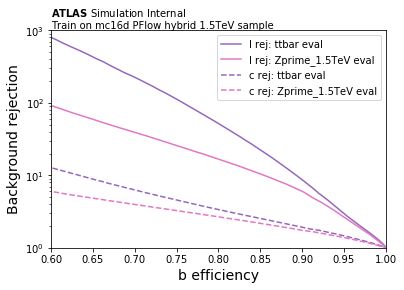

In [16]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+="Train on mc16d PFlow {} sample".format(HYBRID_SAMPLE.replace("_"," "))

btagROC(beffs, leffs, ceffs, ['ttbar eval','Zprime_1.5TeV eval'],
        colors=['C4','C6'], text=text, figDir=figDir,
        subDir='mc16d_PFlow_{}'.format(HYBRID_SAMPLE),tag='ttbar_Zprime_eval')

## 3. C.f. the dedicated $t\bar{t}$ training  <a id='cf_ttbarTraining'></a>

In [17]:
subDir

'mc16d_PFlow_Zprime_1.5TeV'

Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


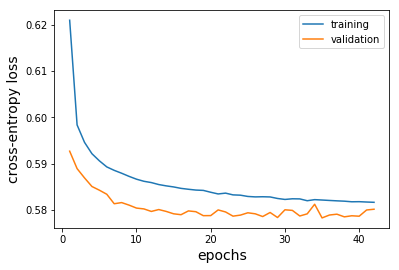

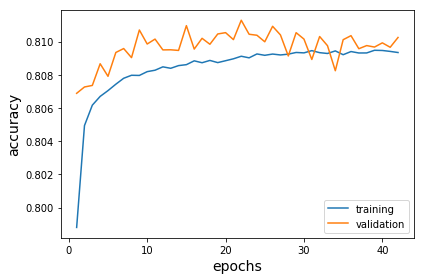

min: -6.61, max: 11.12


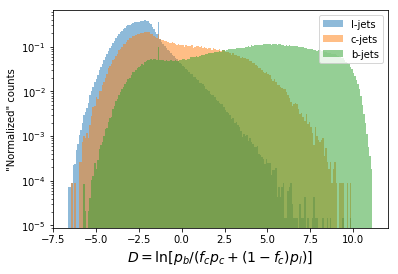

In [19]:
# Step 1: Open the file
subDir = 'mc16d_PFlow_ttbar'
dataDir = '../../data/'+subDir
dataTagTest = "2mtest_15trks_{}_sd0_rev".format(vStr)
dataTagTrain = "3mtrain_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)

f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

# Additionally, get the jet pts for this study
dataDir = '../../data/'+subDir
df = pd.read_hdf('{}/jet_2mtest_15trks_sd0_rev.h5'.format(dataDir), key='jet_df')

# For the test set, you don't need ix
jetPts.append(df.pt)
ys.append(y)

# Step 2: Get the model
modelDir = '../../models/'+subDir
m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, dataTag=dataTagTrain, loadModel=True)
trainingMetrics(m.modelName,modelDir=modelDir)
    

# Get the discriminant
(leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                  figDir=figDir,subDir=subDir)

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)
discs.append(d)

In [ ]:
nTest=1.5e6

In [ ]:
colors = ['C4','C2']
labels = [r'hybrid training: $t\bar{t}$ eval',r'$t\bar{t}$ training: $t\bar{t}$ eval']

subDir='mc16d_PFlow_{}'.format(HYBRID_SAMPLE)

plotROCRatio([beffs[0],beffs[2]], [leffs[0],leffs[2]], labels, rrange=(0.8,1.1),ymax=1000,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_cf_hybrid_ttbar_train')

plotROCRatio([beffs[0],beffs[2]], [ceffs[0],ceffs[2]], labels, rrange=(0.8,1.11),ymax=100,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_cf_hybrid_ttbar_train')

In [ ]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

for yi,flav in enumerate(['l','c','b']):
    
    var  = jetPts[-1]
    mask = (ys[-1]==yi)
    
    plt.hist(var[mask],label='{} jets'.format(flav),
             bins=150,range=(0,1500),
             histtype='step',log=True)
    
ymax = 3e5
plt.ylim(.1,3e5)
    
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.text(0,ymax,text,horizontalalignment='left', verticalalignment='bottom')
plt.legend()

plt.savefig('../../figures/mc16d_PFlow_ttbar/jet_pT.pdf')

plt.show()

**Next: Let's look at the $p_T$ dependence**

From my notebook `IP3D-Gains`, I developed a function `plotPtDependence` from which I should be good to go... all I need is to add error bars!

**Question:** Is the hybrid sample doing what we expect, i.e, is it helping us at high $p_T$?

Plan: C.f. these curves with the $t\bar{t}$ training, evaluated on $t\bar{t}$.

Look at these $p_T$ dependent rejections for the two models overlaid on top of eachother.

**Step 1:** Are the $p_T$ profiles for the models w/ the two different scalings the same?

They have to be... b/c I think I'm grabbing them out of the same file!

**Step 2:** Are the y-labels the same (I hope so, otherwise something is messed up!)


In [ ]:
len(discs)

In [ ]:
(ys[0]!=ys[2]).sum()

Good news: Yes! This is the case, so all I have to do now is overlay the two curves

In [ ]:
[discs[0],discs[2]]

In [ ]:
subDir

In [ ]:
plotPtDependence(jetPts[0],ys[0],[discs[0],discs[2]], labels,
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 1000]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,600,700,800,900,1000]),
                 figDir=figDir,subDir=subDir,tag='cf_trainSamples_ttbar_eval')

## Suggestion from Franscesco

Let's look into the performance of these taggers on the Z' sample with smaller bins to represent our better statistics!

### Step 1: Plot the Z' $p_T$ spectrum

In [ ]:
text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow Z' 1.5 TeV sample"

for yi,flav in enumerate(['l','c','b']):
    
    var  = jetPts[1]
    mask = (ys[1]==yi)
    
    plt.hist(var[mask],label='{} jets'.format(flav),
             bins=150,range=(0,1500),
             histtype='step',log=True)
    
plt.xlabel('jet $p_T$ [GeV]',fontsize=14)
plt.legend()
ymax=3e5
plt.ylim(.1,ymax)
plt.text(0,ymax,text,horizontalalignment='left', verticalalignment='bottom')

plt.savefig('../../figures/mc16d_PFlow_Zprime_1.5TeV/jet_pT.pdf')
plt.show()

### $t\bar{t}$ training evaluated on the Z' sample

So, I was curious if I could compare the hybrid and ttbar trainings on Z', since this sample has *more* high $p_T$ stats! 

In [ ]:
# Open the Z' file
subDir = 'mc16d_PFlow_Zprime_1.5TeV'
dataDir = '../../data/'+subDir
dataTag = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}_ttbarScale.hdf5".format(dataDir,dataTagTest)

f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

# Additionally, get the jet pts for this study
dataDir = '../../data/'+subDir
df = pd.read_hdf('{}/jet_2mtest_15trks_sd0_rev.h5'.format(dataDir), key='jet_df')

# For the test set, you don't need ix
jetPts.append(df.pt)
ys.append(y)


# Get the discriminant
(leff, ceff, beff), d = sigBkgEff(m, X, y, ix, returnDisc=True,
                                  figDir=figDir,subDir=subDir,
                                  tag='ttbar_train')

leffs.append(leff)
ceffs.append(ceff)
beffs.append(beff)
discs.append(d)

In [ ]:
labels = ['{}hybrid training: Z\' eval'.format('' if '1.5TeV' in HYBRID_SAMPLE else 'extended '),
          'ttbar training: Z\' eval']

plotROCRatio([beffs[1],beffs[-1]], [leffs[1],leffs[-1]], labels, rrange=(0.1,1.1),ymax=100,
             text=text,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='lrej_cf_hybrid_ttbar_train_Zprime_1.5TeV')

plotROCRatio([beffs[1],beffs[-1]], [ceffs[1],ceffs[-1]], labels, rrange=(0.1,1.1),ymax=10,
             text=text,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir,tag='crej_cf_hybrid_ttbar_train_Zprime_1.5TeV')

In [ ]:
(jetPts[1]!=jetPts[-1]).sum()

In [ ]:
(ys[1]!=ys[-1]).sum()

In [ ]:
subDir='mc16d_PFlow_Zprime_1.5TeV'

In [ ]:
plotPtDependence(jetPts[1],ys[1],[discs[1],discs[-1]], labels,
                 lrej_lim=(0,300),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 1000,1500]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,600,700,800,900,1000,1250,1500]),
                 figDir=figDir,subDir=subDir,tag='cf_trainSamples_Zprime_eval')

**Plan:** To focus on the performance gains at high $p_T$, zoom into larger than 250 GeV.

In [ ]:
ptmin = 250
ptmax = 1500
step1 = 10
step2 = 50

plotPtDependence(jetPts[1],ys[1],[discs[1],discs[-1]],labels,
                 lrej_lim=(0,100),crej_lim=(0,5),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text,
                 pt_edges=np.linspace(ptmin,ptmax+step1,step1),
                 eff_bins = np.linspace(ptmin,ptmax+step2,step2),
                 figDir=figDir,subDir=subDir,tag=tag='cf_trainSamples_Zprime_eval_highPt')

Recall: I had rejections of about 800 before with EMTopo. If this is an optimization issue, I could
1. Train w/ more jets
2. Look into some different reweighting schemes, such as the $p_T$ reweighting scheme that Manuel is using!

(I think he's just reweighting each bin to whichever option has the lowest stats.)

### Jet weights

Ok, so currently I'm reweighting the $p_T$s l-jet spectrum, but one of the comments from the algs meeting was that it might be nicer to instead look at reweighting to the b-jet spectrum for the hybrid training files b/c 

In [ ]:
plt.hist(df[''],bins=80,range=(0,80))
plt.show()